# Raport: Wykrywanie anomalii w rzeczywistych zbiorach danych

##### Wykonał: Andrii Sonsiadlo
##### Nr albumu: 245576


W celu przeprowadzenia eksperymentów z wykrywaniem anomalii, wybrano zbiory danych o różnych rozmiarach i wymiarach.
Statystyki opisowe dla każdego zbioru zostały przedstawione w następnej częci raportu.
Dla wykonania eksperymentów na wybranych metodach zbiory danych byli podzielone na zbiory treningowy i testowy w proporcji 1:1.

| Dataset | Description             | Size  |  DIM  | OOD           |
|---------|-------------------------|-------|:-----:|---------------|
| Thyroid | Thyroid disease         | 3772  |   6   | 93 (2.47 %)   |
| Shuttle | Shuttle landing control | 49097 |   9   | 3511 (7.15 %) |
| Vowels  | Vowels recognition      | 1456  |  12   | 50 (3.43 %)   |

Wykorzystane algorytmy do wykrywania anomalii:
- *Isolation Forest*
- *Local Outlier Factor*
- *Support Vector Machine*

Zastosowane metryki dla określenia jakości algorytmów:
- *Accuracy*
- *Precision*
- *Recall*
- *F1*
- *ROC (TPR, FPR)*
- *AUC*
- *Confusion Matrix*

Zbiory danych zostały pobrane z: [link](http://odds.cs.stonybrook.edu/)

### Importing libraries

In [270]:
%matplotlib widget

from collections import defaultdict
from typing import Optional

import numpy as np
import pandas as pd
import scipy.io
import seaborn as sns
from matplotlib import pyplot as plt
from pandas import DataFrame
from pydantic import BaseModel
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.svm import OneClassSVM


### Configuring pandas

In [271]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1200)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

### Loading datasets

In [272]:
from pydantic import Field


class DF(DataFrame):
    @classmethod
    def __get_validators__(cls):
        yield cls.validate

    @classmethod
    def validate(cls, v):
        if not isinstance(v, DataFrame):
            raise ValueError('Expected DataFrame from pandas')
        return v

    def __repr__(self):
        return f'DataFrame({super().__repr__()})'

    def __str__(self):
        return f'DataFrame({super().__str__()})'


class Dataset(BaseModel):
    class Config:
        arbitrary_types_allowed = True
        repr_html = True
        validate_assignment = True

    name: str
    x: DF = Field(repr=False)
    y: DF = Field(repr=False)

    x_train: Optional[DF]
    y_train: Optional[DF]
    x_test: Optional[DF]
    y_test: Optional[DF]

    y_pred: Optional[DF]
    scores_pred: Optional[DF]

    def split_data(self):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.x, self.y, test_size=0.5,
                                                                                shuffle=True)
        return self

In [273]:
from sklearn.preprocessing import StandardScaler


def load_datasets(dataset_names: tuple, verbose: bool = False):
    datasets = defaultdict(Dataset)
    for dataset_name in dataset_names:
        raw_data = scipy.io.loadmat(f'../datasets/{dataset_name}.mat')

        x = np.array(raw_data.get('X'))
        y = np.array(raw_data.get('y')).ravel().astype(dtype=np.uint8)

        x = StandardScaler().fit_transform(x)

        # TODO: split into train and test dataset, use splitted datasets in experiments
        dataset = Dataset(
            name=dataset_name,
            x=DataFrame(x, columns=[f'x{i}' for i in range(1, x.shape[1] + 1)]),
            y=DataFrame(y, columns=["class"]),
        ).split_data()
        if verbose:
            print(
                f"Name: {dataset.name}\n"
                f"X: {dataset.x.shape}\n"
                f"Y: {dataset.y.shape}\n"
                f"OOD: {(ood := np.count_nonzero(dataset.y == 1))} ({round((ood * 100) / len(dataset.y), 2)} %)\n"
            )
        datasets[dataset_name] = dataset
    return datasets


DATASET_NAMES = ('thyroid', 'shuttle', 'vowels')
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=True)

Name: thyroid
X: (3772, 6)
Y: (3772, 1)
OOD: 93 (2.47 %)

Name: shuttle
X: (49097, 9)
Y: (49097, 1)
OOD: 3511 (7.15 %)

Name: vowels
X: (1456, 12)
Y: (1456, 1)
OOD: 50 (3.43 %)



### Statistics functions

In [274]:
def accuracy_report(dataset: Dataset):
    print("Accuracy Score :", accuracy_score(dataset.y_test, dataset.y_pred))
    print("Classification Report :\n", classification_report(dataset.y_test, dataset.y_pred))

In [275]:
def corr_map_plot(dataset: Dataset, figsize=(20, 20)):
    # get correlations of each features in dataset
    corrmat = dataset.x.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=figsize)
    plt.title(f"Correlation map for {dataset.name.capitalize()} dataset")
    #plot heat map
    g = sns.heatmap(dataset.x[top_corr_features].corr(), annot=True, cmap="RdYlGn")
    plt.close()

In [276]:
def conf_matrix_plot(dataset: Dataset):
    cm = confusion_matrix(dataset.y_test, dataset.y_pred)
    df_cm = pd.DataFrame(cm, index = [0, 1],
                  columns = [0, 1])
    plt.figure(figsize = (4,4))
    s = sns.heatmap(df_cm, annot=True, fmt='g', cmap="Blues")
    s.set(xlabel='Predicted label', ylabel='True label', title=f"Confusion matrix for {dataset.name.capitalize()} dataset")
    plt.show()
    plt.close()

In [277]:
def roc_curve_plot(datasets: dict[str, Dataset] | Dataset):
    if isinstance(datasets, Dataset):
        datasets = {datasets.name: datasets}

    plt.figure(figsize=(7,7))
    for name, dataset in datasets.items():
        fpr, tpr, thresh = roc_curve(dataset.y_test, dataset.scores_pred)
        auc = roc_auc_score(dataset.y_test, dataset.scores_pred)
        plt.plot(tpr, fpr, label=f"Dataset: {dataset.name}, auc={round(1 - auc, 3)}")

    plt.plot([0, 1], [0, 1], "k--")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc=0)
    plt.show()
    plt.close()

In [278]:
%matplotlib widget

def plot_3d(dataset: Dataset, dims: tuple[int, int, int]):
    x_index = dims[0]
    y_index = dims[1]
    z_index = dims[2]

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(dataset.x.iloc[:, x_index], dataset.x.iloc[:, y_index], dataset.x.iloc[:, z_index], c=dataset.y, cmap='rainbow')
    ax.set_xlabel(dataset.x.columns[x_index])
    ax.set_ylabel(dataset.x.columns[y_index])
    ax.set_zlabel(dataset.x.columns[z_index])
    plt.show()
    plt.close()

# Datasets

## Thyroid dataset

In [279]:
thyroid = datasets["thyroid"]
thyroid.x.head()

,x1,x2,x3,x4,x5,x6
0,1.134,-0.179,-0.700,0.340,-0.929,1.070
1,-1.452,-0.194,1.322,1.007,1.811,-0.064
2,-0.238,-0.123,0.513,-0.182,1.704,-0.960
3,0.659,-0.166,-0.430,-0.907,-0.499,-0.751
4,-1.504,-0.194,0.783,0.891,-0.499,1.279


In [280]:
thyroid.x.describe()

,x1,x2,x3,x4,x5,x6
count,3.772e+03,3772.000,3.772e+03,3.772e+03,3.772e+03,3.772e+03
mean,4.050e-16,0.000,-3.278e-16,2.675e-16,-1.582e-16,1.498e-16
std,1.000e+00,1.000,1.000e+00,1.000e+00,1.000e+00,1.000e+00
min,-2.665e+00,-0.204,-2.654e+00,-3.082e+00,-4.314e+00,-3.230e+00
25%,-8.185e-01,-0.179,-4.301e-01,-5.593e-01,-5.528e-01,-5.122e-01
50%,1.314e-01,-0.136,5.506e-02,-8.080e-02,-1.550e-02,-6.431e-02
75%,8.174e-01,-0.101,3.785e-01,4.267e-01,4.144e-01,3.537e-01
max,2.242e+00,22.537,1.155e+01,9.330e+00,7.131e+00,1.499e+01


array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>,
        <Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x4'}>,
        <Axes: title={'center': 'x5'}>, <Axes: title={'center': 'x6'}>]],
      dtype=object)

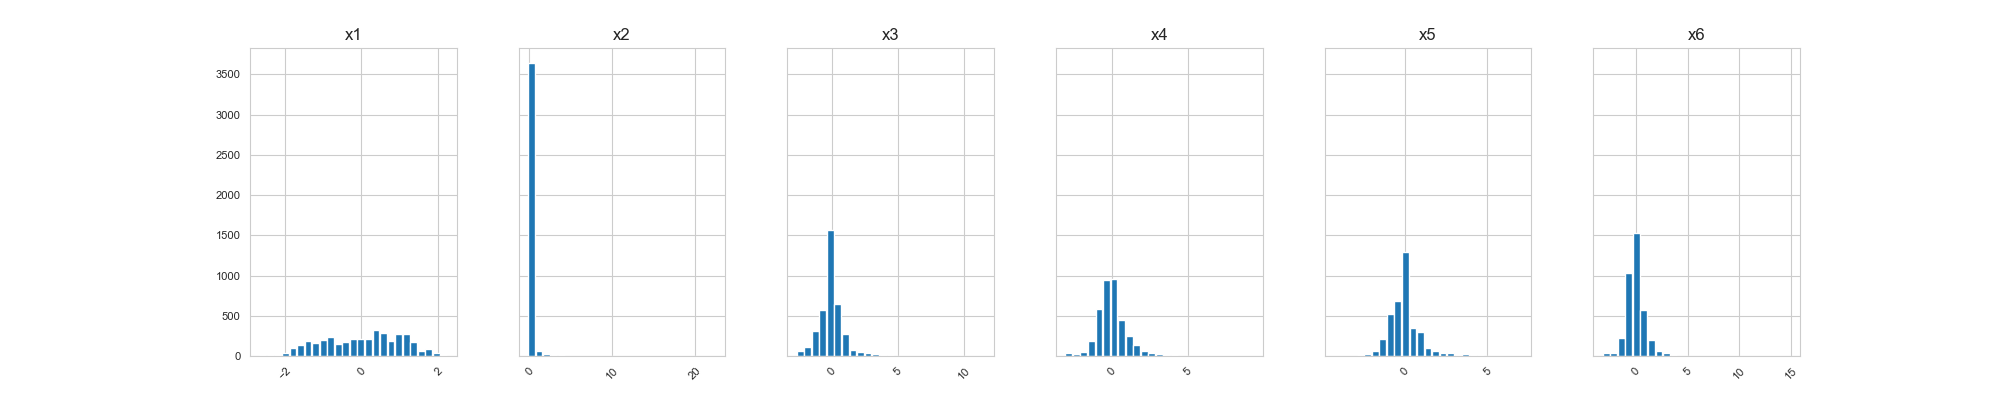

In [281]:
thyroid.x.hist(figsize=(20, 4), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(1, 6), sharey=True, zorder=2,
               rwidth=0.9)

In [282]:
thyroid.y.describe()

,class
count,3772.000
mean,0.025
std,0.155
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [283]:
thyroid.y.value_counts()

class
0        3679
1          93
Name: count, dtype: int64

In [284]:
corr_map_plot(thyroid, figsize=(6, 6))

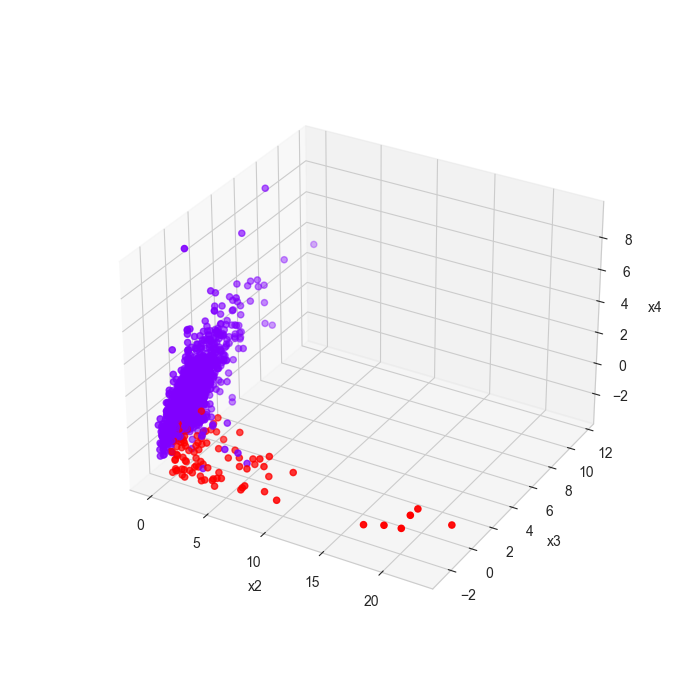

In [285]:
plot_3d(thyroid, dims=(1, 2, 3))

## Shuttle dataset

In [286]:
shuttle = datasets["shuttle"]
shuttle.x.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.238,2.488e-01,-0.915,-0.006,-0.444,-0.010,-0.833,-0.014,0.494
1,0.471,7.553e-04,-0.352,-0.006,0.758,-0.033,-0.684,-0.889,-0.348
2,-0.771,7.553e-04,-1.028,-0.006,-0.444,0.073,0.134,-0.014,-0.095
3,-0.771,7.553e-04,-0.690,-0.006,-0.144,-0.129,0.357,-0.111,-0.348
4,2.957,7.553e-04,0.324,-0.112,-1.546,-0.005,-2.618,1.687,2.936


In [287]:
shuttle.x.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9
count,4.910e+04,4.910e+04,4.910e+04,4.910e+04,4.910e+04,4.910e+04,4.910e+04,4.910e+04,4.910e+04
mean,1.515e-16,2.316e-18,-6.136e-17,4.052e-18,1.857e-16,3.329e-18,1.187e-17,-1.395e-16,-2.721e-17
std,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00,1.000e+00
min,-1.548e+00,-5.694e+01,-7.223e+00,-1.048e+02,-1.126e+01,-1.225e+02,-6.411e+00,-1.951e+01,-1.542e+01
25%,-7.714e-01,7.553e-04,-6.897e-01,-5.674e-03,-3.442e-01,-2.822e-02,-3.868e-01,-6.460e-01,-4.321e-01
50%,-2.278e-01,7.553e-04,-2.392e-01,-5.674e-03,2.569e-01,-9.894e-03,5.944e-02,-3.543e-01,-3.479e-01
75%,2.383e-01,7.553e-04,3.241e-01,-5.674e-03,4.573e-01,1.301e-02,3.569e-01,3.262e-01,-1.794e-01
max,6.141e+00,5.994e+01,7.195e+00,1.019e+02,1.999e+01,6.945e+01,4.968e+00,1.078e+01,1.077e+01


array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>,
        <Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x4'}>,
        <Axes: title={'center': 'x5'}>, <Axes: title={'center': 'x6'}>,
        <Axes: title={'center': 'x7'}>, <Axes: title={'center': 'x8'}>,
        <Axes: title={'center': 'x9'}>]], dtype=object)

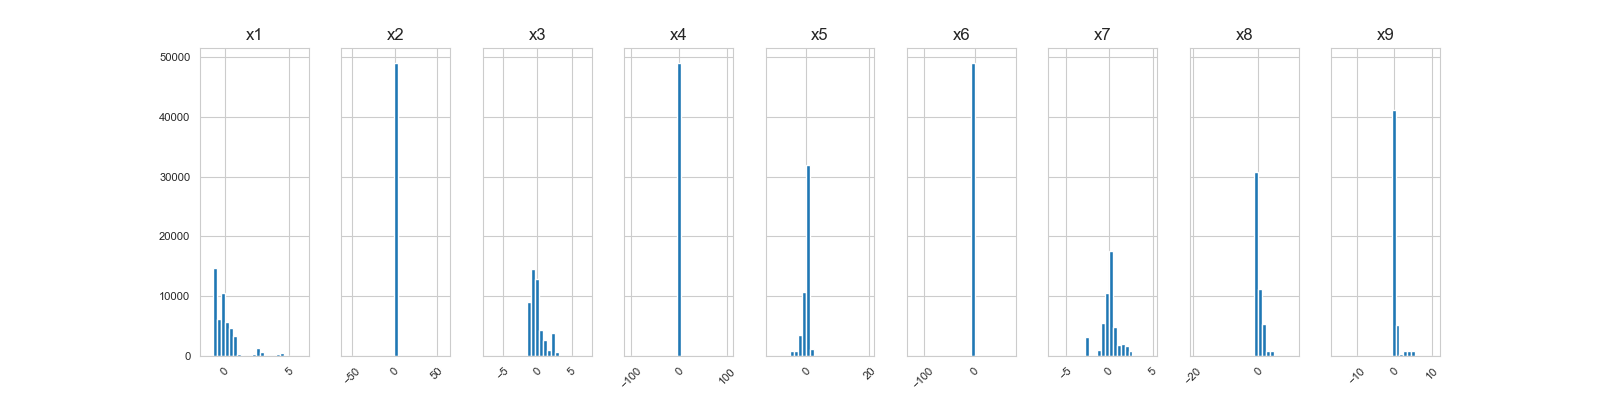

In [288]:
shuttle.x.hist(figsize=(16, 4), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(1, 9), sharey=True)

In [289]:
shuttle.y.describe()

,class
count,49097.000
mean,0.072
std,0.258
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [290]:
shuttle.y.value_counts()

class
0        45586
1         3511
Name: count, dtype: int64

In [291]:
corr_map_plot(shuttle, figsize=(9, 9))

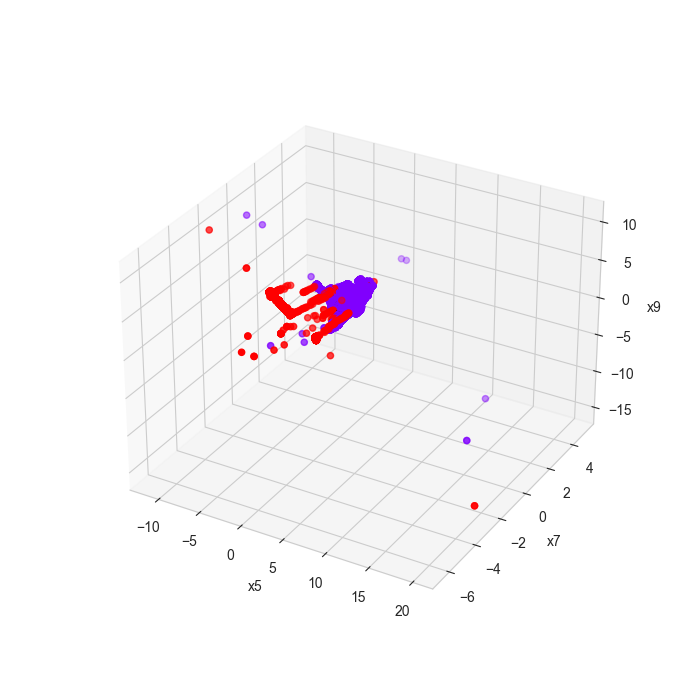

In [292]:
plot_3d(shuttle, dims=(4, 6, 8))

## Vowels dataset

In [293]:
vowels = datasets["vowels"]
vowels.x.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,0.581,-0.903,0.618,-0.998,-2.465,-0.847,2.351,0.376,-0.650,1.605,-0.623,-0.383
1,0.785,-1.078,0.616,-0.922,-2.389,-0.638,2.107,0.361,-0.715,1.261,-0.423,-0.288
2,0.792,-1.087,0.670,-0.806,-2.262,-0.539,2.054,0.267,-0.843,1.082,-0.267,-0.172
3,1.218,-1.084,0.856,-0.725,-2.156,-0.102,1.769,0.303,-1.045,0.656,0.214,-0.342
4,1.066,-1.031,0.774,-0.452,-1.957,0.248,1.531,0.254,-0.969,-0.208,0.332,0.007


In [294]:
vowels.x.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
count,1456.000,1.456e+03,1.456e+03,1456.000,1.456e+03,1456.000,1.456e+03,1.456e+03,1.456e+03,1456.000,1.456e+03,1.456e+03
mean,0.000,-3.904e-17,-1.171e-16,0.000,-3.904e-17,0.000,-3.904e-17,1.952e-17,3.904e-17,0.000,-9.760e-18,1.952e-17
std,1.000,1.000e+00,1.000e+00,1.000,1.000e+00,1.000,1.000e+00,1.000e+00,1.000e+00,1.000,1.000e+00,1.000e+00
min,-2.868,-2.699e+00,-2.205e+00,-2.185,-3.137e+00,-3.489,-3.044e+00,-2.330e+00,-1.673e+00,-3.078,-3.366e+00,-3.176e+00
25%,-0.703,-7.999e-01,-8.440e-01,-0.807,-6.361e-01,-0.656,-6.195e-01,-7.643e-01,-9.563e-01,-0.676,-5.773e-01,-5.841e-01
50%,0.013,-4.554e-02,1.080e-01,-0.032,5.697e-02,0.052,-1.074e-01,-3.722e-02,-6.763e-02,-0.039,9.035e-02,8.081e-02
75%,0.717,8.470e-01,8.515e-01,0.789,7.768e-01,0.711,5.369e-01,6.627e-01,8.739e-01,0.661,7.177e-01,6.745e-01
max,3.648,2.307e+00,2.255e+00,2.912,2.690e+00,3.037,3.562e+00,3.224e+00,2.539e+00,3.934,2.362e+00,3.210e+00


array([[<Axes: title={'center': 'x1'}>, <Axes: title={'center': 'x2'}>,
        <Axes: title={'center': 'x3'}>, <Axes: title={'center': 'x4'}>,
        <Axes: title={'center': 'x5'}>, <Axes: title={'center': 'x6'}>,
        <Axes: title={'center': 'x7'}>, <Axes: title={'center': 'x8'}>,
        <Axes: title={'center': 'x9'}>, <Axes: title={'center': 'x10'}>,
        <Axes: title={'center': 'x11'}>, <Axes: title={'center': 'x12'}>]],
      dtype=object)

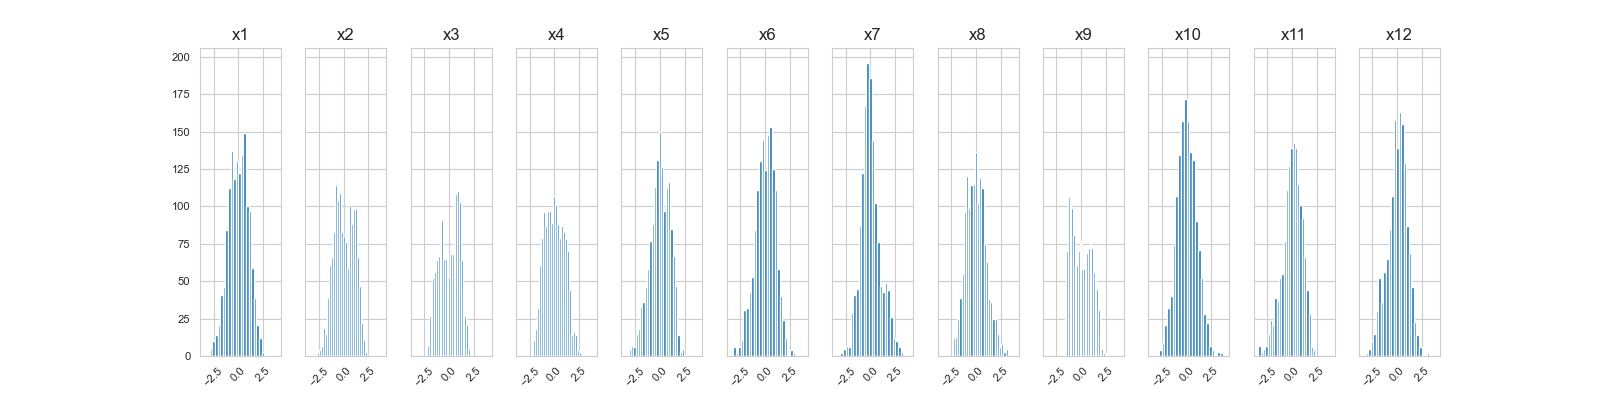

In [295]:
vowels.x.hist(figsize=(16, 4), bins=25, xlabelsize=8, ylabelsize=8, xrot=45, layout=(1, 12), sharey=True, sharex=True)

In [296]:
vowels.y.describe()

,class
count,1456.000
mean,0.034
std,0.182
min,0.000
25%,0.000
50%,0.000
75%,0.000
max,1.000


In [297]:
shuttle.y.value_counts()

class
0        45586
1         3511
Name: count, dtype: int64

In [298]:
corr_map_plot(vowels, figsize=(8, 8))

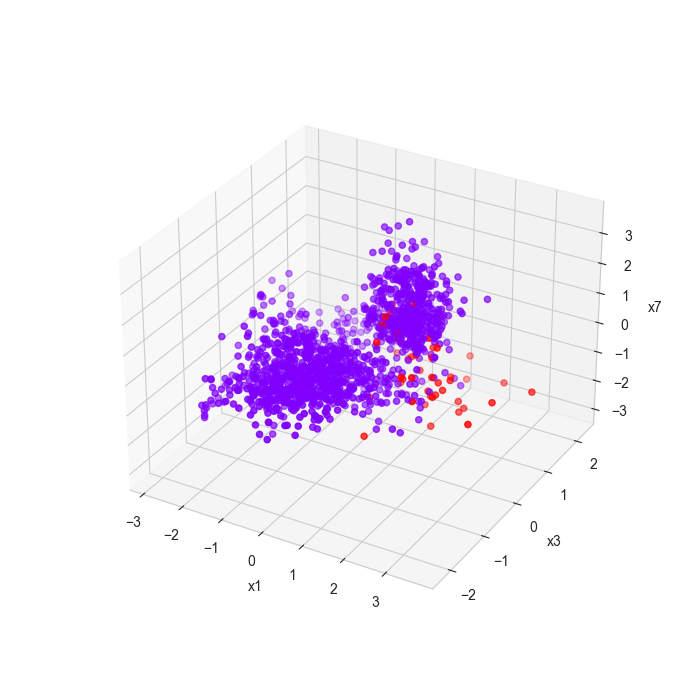

In [299]:
plot_3d(vowels, dims=(0, 2, 6))

# Experiments

## Local Outlier Factor

In [300]:
def preprocess_y(y: np.ndarray):
    return np.where(y == 1, 0, 1)

In [301]:
def local_outlier_factor(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = LocalOutlierFactor(n_neighbors=20, contamination='auto', leaf_size=30, p=5)
    # model = LocalOutlierFactor(
    #     n_neighbors=20, algorithm='auto',
    #     leaf_size=30, metric='minkowski',
    #     p=2, metric_params=None, contamination='auto'
    # )
    model.fit(dataset.x_train)
    dataset.y_pred = DataFrame(preprocess_y(model.fit_predict(dataset.x_test)), columns=["class"])
    dataset.scores_pred = DataFrame(model.negative_outlier_factor_)

***************************************** DATASET THYROID ******************************************

Accuracy Score : 0.9512195121951219
Classification Report :
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      1840
           1       0.21      0.35      0.26        46

    accuracy                           0.95      1886
   macro avg       0.59      0.66      0.62      1886
weighted avg       0.96      0.95      0.96      1886



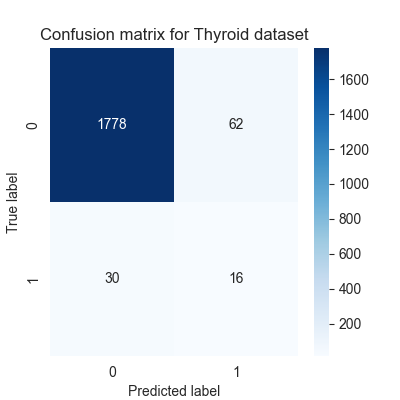

***************************************** DATASET SHUTTLE ******************************************

Accuracy Score : 0.9096500875799421
Classification Report :
               precision    recall  f1-score   support

           0       0.93      0.97      0.95     22820
           1       0.20      0.09      0.13      1729

    accuracy                           0.91     24549
   macro avg       0.57      0.53      0.54     24549
weighted avg       0.88      0.91      0.89     24549



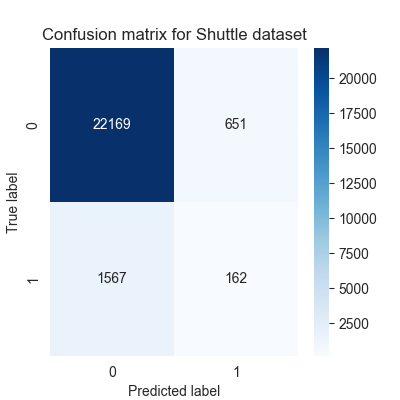

****************************************** DATASET VOWELS ******************************************

Accuracy Score : 0.967032967032967
Classification Report :
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       706
           1       0.44      0.32      0.37        22

    accuracy                           0.97       728
   macro avg       0.71      0.65      0.68       728
weighted avg       0.96      0.97      0.96       728



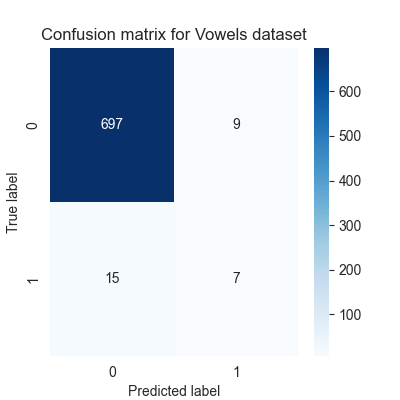

In [302]:
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=False)

for dataset in datasets.values():
    local_outlier_factor(dataset)
    accuracy_report(dataset)
    conf_matrix_plot(dataset)

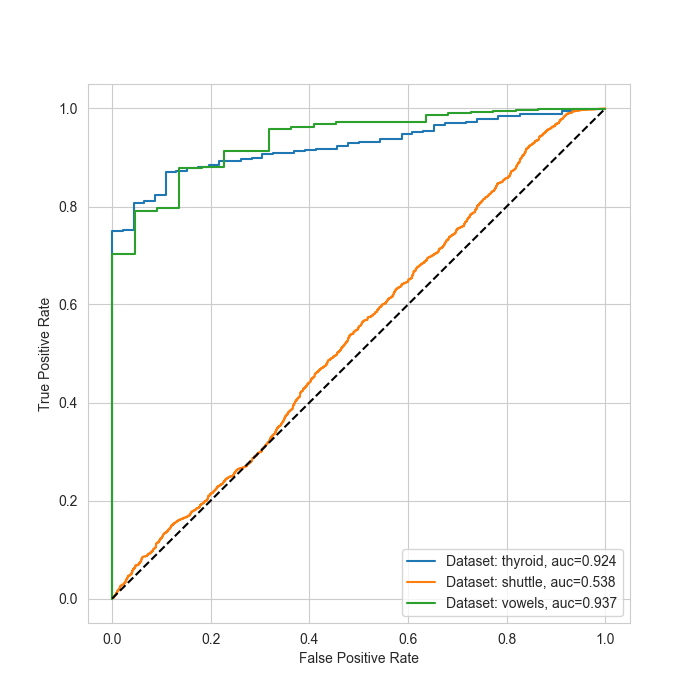

In [303]:
roc_curve_plot(datasets)

# Isolation Forest

In [304]:
def isolation_forest(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = IsolationForest(
        n_estimators=200,
        max_samples="auto",
        contamination="auto"
    )
    model.fit(dataset.x)
    dataset.y_pred = DataFrame(preprocess_y(model.predict(dataset.x_test)))
    dataset.scores_pred = DataFrame(model.decision_function(dataset.x_test))


***************************************** DATASET THYROID ******************************************

Accuracy Score : 0.9337221633085896
Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.93      0.96      1835
           1       0.28      0.96      0.44        51

    accuracy                           0.93      1886
   macro avg       0.64      0.95      0.70      1886
weighted avg       0.98      0.93      0.95      1886



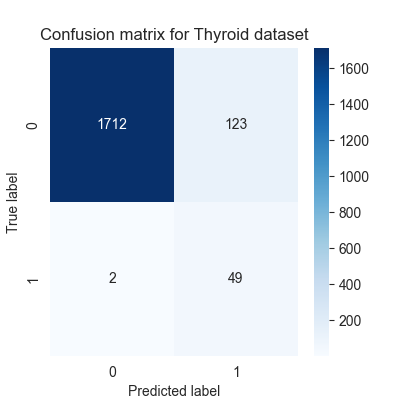

***************************************** DATASET SHUTTLE ******************************************

Accuracy Score : 0.960446454030714
Classification Report :
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     22776
           1       0.65      0.99      0.78      1773

    accuracy                           0.96     24549
   macro avg       0.82      0.97      0.88     24549
weighted avg       0.97      0.96      0.96     24549



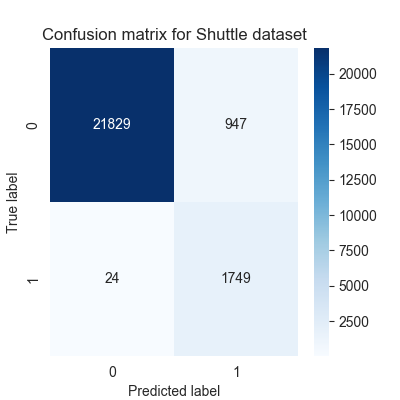

****************************************** DATASET VOWELS ******************************************

Accuracy Score : 0.896978021978022
Classification Report :
               precision    recall  f1-score   support

           0       0.97      0.92      0.94       700
           1       0.15      0.36      0.21        28

    accuracy                           0.90       728
   macro avg       0.56      0.64      0.58       728
weighted avg       0.94      0.90      0.92       728



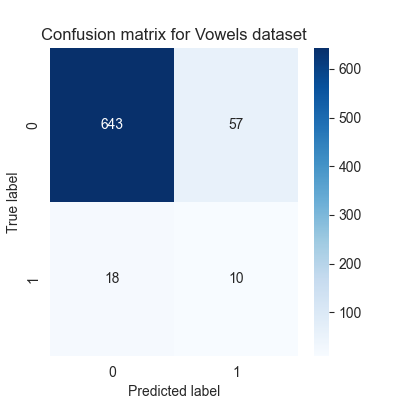

In [305]:
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=False)

for name, dataset in datasets.items():
    isolation_forest(dataset)
    accuracy_report(dataset)
    conf_matrix_plot(dataset)

#### ROC curve

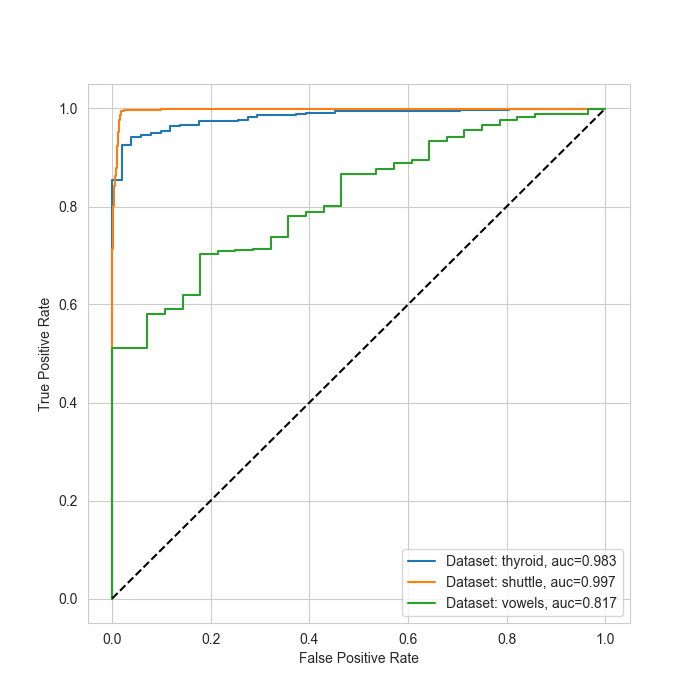

In [306]:
roc_curve_plot(datasets)

## k-Nearest Neighbors

In [307]:
def knn2(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")

    model = NearestNeighbors(n_neighbors=5)
    model.fit(dataset.x)

    # distances and indexes of k-neaighbors from model outputs
    distances, indexes = model.kneighbors(dataset.x)
    # plot mean of k-distances of each observation
    plt.plot(distances.mean(axis=1))
    # dataset.y_pred = DataFrame(preprocess_y(model.predict(dataset.x)))
    # dataset.scores_pred = model.predict_proba(dataset.x)[:, 1]
    print(distances)
    print(indexes)
    outlier_index = np.where(distances.mean(axis=1) > 0.15)
    # print(outlier_index)
    # dataset.y_pred = dataset.y.to_numpy().copy()[:] = 0
    # dataset.y_pred[outlier_index] = 1
    accuracy_report(dataset)

In [308]:
def knn(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = NearestNeighbors(n_neighbors=20, p=5)
    model.fit(dataset.x_train)

    distances, indexes = model.kneighbors(dataset.x_test)
    dataset.scores_pred = DataFrame(np.mean(distances, axis=1))
    threshold = np.percentile(dataset.scores_pred, 95)
    dataset.y_pred = DataFrame(np.where(dataset.scores_pred > threshold, 1, 0))

In [309]:
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=False)

for name, dataset in datasets.items():
    knn(dataset)
    accuracy_report(dataset)

***************************************** DATASET THYROID ******************************************

Accuracy Score : 0.9597030752916225
Classification Report :
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1835
           1       0.37      0.69      0.48        51

    accuracy                           0.96      1886
   macro avg       0.68      0.83      0.73      1886
weighted avg       0.97      0.96      0.97      1886

***************************************** DATASET SHUTTLE ******************************************

Accuracy Score : 0.9011365025051937
Classification Report :
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     22744
           1       0.25      0.17      0.20      1805

    accuracy                           0.90     24549
   macro avg       0.59      0.56      0.57     24549
weighted avg       0.88      0.90      0.89     24549

********************

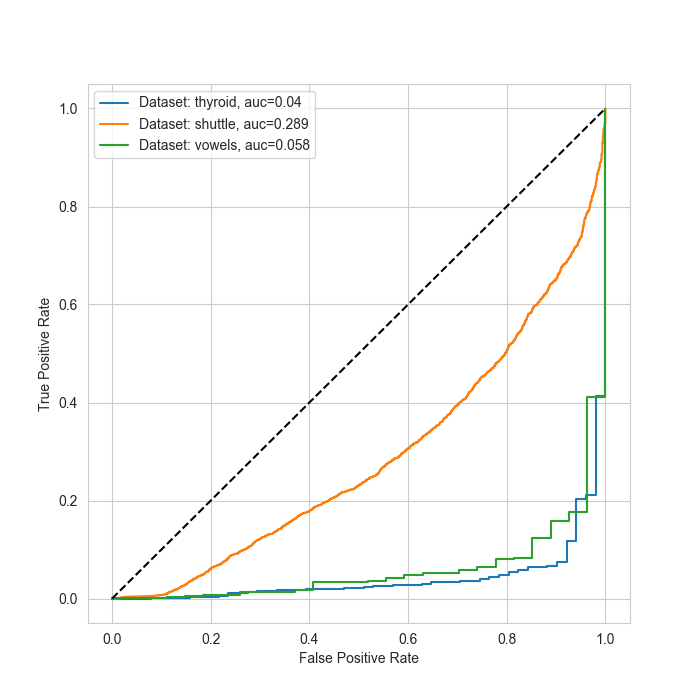

In [310]:
roc_curve_plot(datasets)

## One-Class SVM

In [311]:
def svm(dataset: Dataset):
    print(f"{' DATASET ' + dataset.name.upper() + ' ':*^100}\n")
    model = OneClassSVM(kernel='rbf', nu=0.2)
    model.fit(dataset.x_train)

    dataset.scores_pred = DataFrame(model.decision_function(dataset.x_test))

    threshold = np.percentile(dataset.scores_pred, 95)
    dataset.y_pred = DataFrame(np.where(dataset.scores_pred > threshold, 1, 0))

***************************************** DATASET THYROID ******************************************

Accuracy Score : 0.9236479321314952
Classification Report :
               precision    recall  f1-score   support

           0       0.97      0.95      0.96      1831
           1       0.00      0.00      0.00        55

    accuracy                           0.92      1886
   macro avg       0.48      0.48      0.48      1886
weighted avg       0.94      0.92      0.93      1886



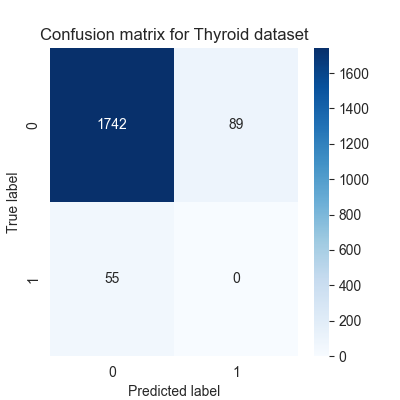

***************************************** DATASET SHUTTLE ******************************************



C:\Users\andrii\AppData\Local\pypoetry\Cache\virtualenvs\anomalydetectionict-i9oc49El-py3.10\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy Score : 0.8796284981058291
Classification Report :
               precision    recall  f1-score   support

           0       0.93      0.95      0.94     22822
           1       0.00      0.00      0.00      1727

    accuracy                           0.88     24549
   macro avg       0.46      0.47      0.47     24549
weighted avg       0.86      0.88      0.87     24549



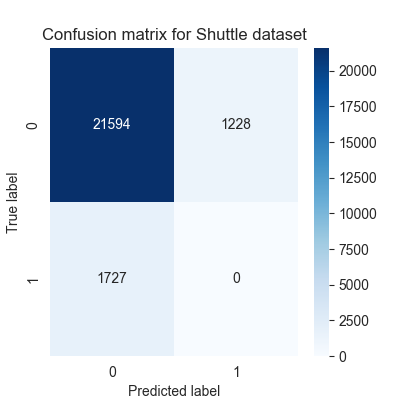

****************************************** DATASET VOWELS ******************************************

Accuracy Score : 0.9134615384615384
Classification Report :
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       702
           1       0.00      0.00      0.00        26

    accuracy                           0.91       728
   macro avg       0.48      0.47      0.48       728
weighted avg       0.93      0.91      0.92       728



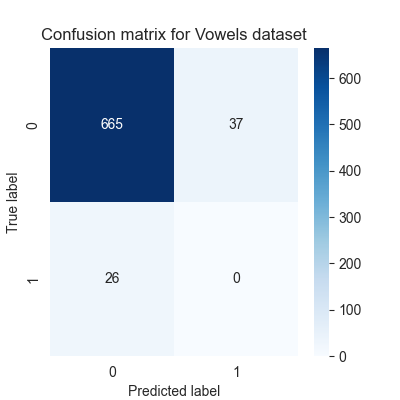

In [312]:
datasets = load_datasets(dataset_names=DATASET_NAMES, verbose=False)

for name, dataset in datasets.items():
    svm(dataset)
    accuracy_report(dataset)
    conf_matrix_plot(dataset)

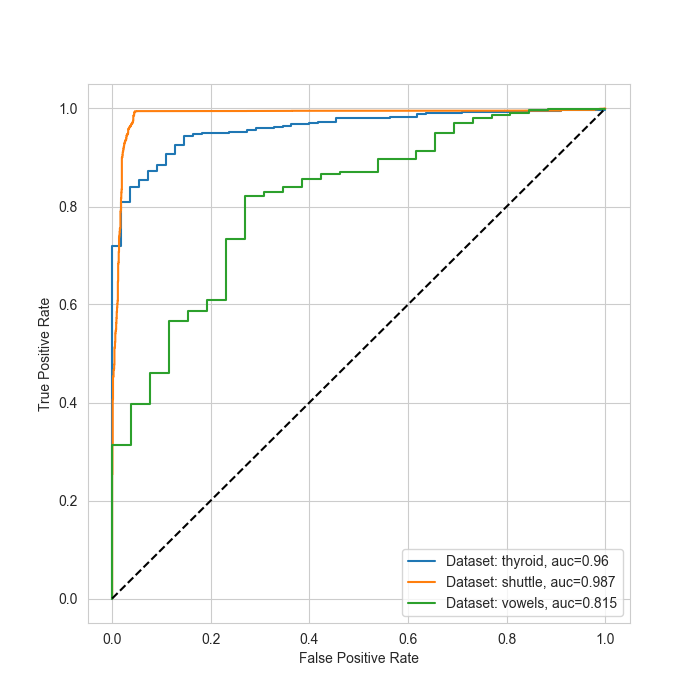

In [313]:
roc_curve_plot(datasets)